你将训练你的第一个扩散模型，用于生成可爱的蝴蝶图像🦋。在此过程中，你将了解🤗 Diffusers 库的核心组件，这将为我们在课程后续内容中介绍的更高级应用打下良好基础。

让我们开始吧！

## 你将学到什么

在本笔记本中，你将：

- 见识一个功能强大的自定义扩散模型 pipeline 的实际应用（并了解如何制作自己的版本）
- 通过以下步骤创建自己的小型管道：
  - 回顾扩散模型背后的核心思想
  - 从 Hub 加载用于训练的数据
  - 探究如何使用 scheduler 向这些数据添加噪声
  - 创建并训练 UNet 模型
  - 将各个部分组合成一个可运行的 pipeline
- 编辑并运行一个脚本，用于初始化更长时间的训练运行，该脚本将处理：
  - 通过🤗 Accelerate 实现多 GPU 训练
  - 实验日志记录，以跟踪关键统计数据
  - 将最终模型上传到 Hugging Face Hub

❓如有任何问题，请在 Hugging Face Discord 服务器的 #diffusion-models-class 频道上发布。如果尚未注册，可在此处注册：https://huggingface.co/join/discord

我们来导入会用到的库，并定义几个便捷函数，这些函数会在后续的 notebook 中使用：

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
import torchvision

def show_images(x):
    """
    接收一批图像张量（batch），将其转换为拼接后的PIL图像。
    输入：
        x: 形状为 (B, C, H, W) 的图像张量，值范围应为 [-1, 1]
    返回：
        PIL.Image 对象，展示了所有图像拼接后的效果
    """
    x = x * 0.5 + 0.5  # 将像素值从 (-1, 1) 映射回 (0, 1)
    grid = torchvision.utils.make_grid(x)  # 将图像拼接成网格
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255  # 转为 (H, W, C)，并放缩到 [0, 255]
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))  # 转为 PIL 图像
    return grid_im

def make_grid(images, size=64):
    """
    将多个 PIL 图像横向拼接成一张图像，方便可视化
    输入：
        images: PIL.Image 对象列表
        size: 每个图像缩放后的尺寸（默认 64x64）
    返回：
        横向拼接后的新图像（PIL.Image）
    """
    output_im = Image.new("RGB", (size * len(images), size))  # 创建空白画布
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))  # 将图像依次贴到画布上
    return output_im

# 设备选择：如果有 GPU 可用则使用 CUDA，否则使用 CPU
# 对于 Mac 用户，可以尝试 'mps' 作为后备（未测试）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 1. 下载训练数据

在这个示例中，我们将使用来自 Hugging Face Hub 的一个包含 1000 张蝴蝶图片的集合。这个数据集非常小，因此我们还提供了一些被注释掉的代码，用于加载更大的数据集选项。如果你更愿意使用自己的图像集合，也可以使用被注释的代码示例从文件夹中加载图片。

In [2]:
# 对于 Windows 用户：
# 设置 HF_ENDPOINT 环境变量为 Hugging Face 镜像源（用于国内加速），
# 然后使用 huggingface-cli 下载数据集到本地指定目录。
!set HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download huggan/smithsonian_butterflies_subset --local-dir ./huggan/smithsonian_butterflies_subset --repo-type dataset

# 对于 Linux/macOS 用户，请使用以下命令（注意使用 export 而不是 set）：
# !export HF_ENDPOINT=https://hf-mirror.com&&huggingface-cli download huggan/smithsonian_butterflies_subset --local-dir ./huggan/smithsonian_butterflies_subset --repo-type dataset

D:\projects\diffusion-models-class-zh\unit1\huggan\smithsonian_butterflies_subset



Fetching 4 files: 100%|██████████| 4/4 [00:00<?, ?it/s]


In [3]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
import torch

# 加载蝴蝶图像数据集的训练集
dataset = load_dataset("./huggan/smithsonian_butterflies_subset", split="train")

# 如果有本地数据，可以用以下方式加载（注释示例）
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# 定义训练用的图像尺寸，训练时将统一调整为32x32像素
image_size = 32

# 批次大小，可以根据GPU内存大小调整
batch_size = 64

# 定义数据预处理和增强步骤
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # 调整图像大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转，增强数据多样性
        transforms.ToTensor(),  # 转换为Tensor，像素值归一化到[0,1]
        transforms.Normalize([0.5], [0.5]),  # 标准化，将[0,1]映射到[-1,1]
    ]
)

def transform(examples):
    """
    对数据集中的每个样本执行预处理，将图像转换成训练所需格式
    输入：
        examples: 一个字典，包含键 'image' 对应的PIL图像列表
    返回：
        字典，键为 'images'，对应预处理后的图像Tensor列表
    """
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

# 将上述预处理应用到整个数据集
dataset.set_transform(transform)

# 创建一个数据加载器
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

d:\Users\yin-pu\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.


我们可以抓取一批图片，然后像这样查看其中的一些：

X shape: torch.Size([8, 3, 32, 32])


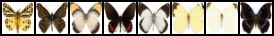

In [4]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb)

## 2.定义调度器（scheduler）
我们的训练方案是对这些输入图像添加噪声，然后将带噪图像送入模型进行训练；在推理阶段，我们则利用模型的预测结果迭代地去除噪声。在 diffusers 中，这两个过程都是由 **scheduler** 来完成的。

noise schedule决定了在不同时间步要添加多少噪声。下面展示了如何基于论文《Denoising Diffusion Probabilistic Models》（https://arxiv.org/abs/2006.11239），使用 “DDPM” 训练与采样的默认设置来创建一个调度器：

In [5]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

### DDPM 中的向前扩散（加噪）过程

> **核心思想**：在每个时间步 $t$，把当前样本 $\mathbf{x}_{t-1}$ **缩放**一下，再 **加一点高斯噪声**，就得到更模糊的 $\mathbf{x}_t$。  
> 随着时间步不断增加，图像会越来越像纯噪声。

---

### 1. 单步加噪公式  

$$
q(\mathbf{x}_t \mid \mathbf{x}_{t-1})
= \mathcal{N}\!\bigl(\mathbf{x}_t;\; \sqrt{1-\beta_t}\,\mathbf{x}_{t-1},\; \beta_t \mathbf{I}\bigr)
$$

- 先乘上 $\sqrt{1-\beta_t}$ → **保留一部分原图信息**  
- 再加方差为 $\beta_t$ 的噪声 → **引入随机扰动**  

连续 $T$ 步后有  
$$
q(\mathbf{x}_{1:T}\mid \mathbf{x}_0)=\prod_{t=1}^{T} q(\mathbf{x}_t \mid \mathbf{x}_{t-1})
$$

---

### 2. 直接计算第 $t$ 步的样本（避免逐步循环）

有时我们想 **直接** 得到第 $t$ 步结果 $\mathbf{x}_t$，而不是循环 $t$ 次。公式如下：

$$
q(\mathbf{x}_t \mid \mathbf{x}_0)
= \mathcal{N}\!\bigl(\mathbf{x}_t;\; \sqrt{\bar{\alpha}_t}\,\mathbf{x}_0,\; (1-\bar{\alpha}_t)\mathbf{I}\bigr)
$$

其中  
$$
\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i, \qquad
\alpha_i = 1 - \beta_i
$$

- $\sqrt{\bar{\alpha}_t}$：**整体保留率**（input 的份额）  
- $\sqrt{1-\bar{\alpha}_t}$：**整体噪声率**（noise 的份额）

---

### 3. 可视化缩放因子  

数学符号看起来总是让人害怕！幸运的是，scheduler帮我们处理了所有这些，scheduler会算出  
* `sqrt_alpha_prod`  = $\sqrt{\bar{\alpha}_t}$ 
* `sqrt_one_minus_alpha_prod` = $\sqrt{1 - \bar{\alpha}_t}$

把这两条曲线画在一张图上，就能直观看到 **“原图信息 vs. 噪声”** 随时间步如何此消彼长，从而更容易理解扩散模型是怎样把图片逐渐“打碎”成噪声的。


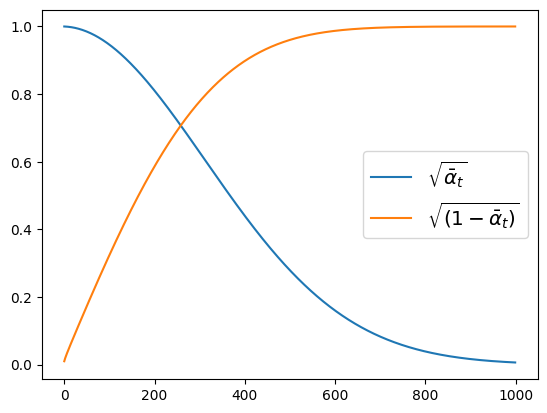

In [6]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

**练习：** 尝试修改 `beta_start`、`beta_end` 或 `beta_schedule` 的取值。  
做法是在代码中 **取消注释**（或替换）下方已经列出的可选配置之一，然后重新运行，观察上面的曲线如何随参数变化而改变。

In [7]:
# 如果想试试“噪声偏少”的配置，可以用：
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)

# 若想采用 “cosine” 调度（对小尺寸图像往往更合适）：
# noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

无论你选用了哪种 **scheduler**，接下来都可以通过 `noise_scheduler.add_noise` 函数在样本中加入不同强度的噪声，示例用法如下：

Noisy X shape torch.Size([8, 3, 32, 32])


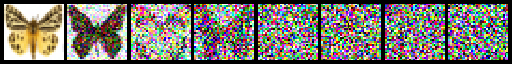

In [8]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## 3.定义模型

大多数扩散模型都会使用某种变体的 [U-Net](https://arxiv.org/abs/1505.04597) 架构，我们这里也不例外。  

![U-Net 结构示意图](./assets/unet-model.png)

简而言之，U-Net 的工作流程：

- **下采样路径**：输入图片依次通过多个 *ResNet* 块，每经过一块，**尺寸减半**（图中绿色部分）。  
- **上采样路径**：随后再通过同样数量的上采样块，将特征**逐步放大**回原始尺寸（图中红色部分）。  
- **跳跃连接**（skip connections）：下采样阶段的特征会直接连接到对应的上采样层，帮助模型同时保留局部细节和全局语义信息。

> **关键特点**：该模型输出的图像与输入图像大小一致——这恰好符合扩散模型在每一步都要“还原”出同尺寸噪声/图像的需求。

在 🤗 **Diffusers** 中，我们可以直接使用 `UNet2DModel` 类（PyTorch 实现）来构建上述架构。

下面我们就为目标图像尺寸创建一个 U-Net：  
- `down_block_types` 对应示意图中的 **绿色**下采样块  
- `up_block_types` 对应示意图中的 **红色**上采样块


In [9]:
from diffusers import UNet2DModel

# ==== 创建 U-Net 模型 ====
model = UNet2DModel(
    sample_size=image_size,      # 目标图像分辨率，例如 32、64、128...
    in_channels=3,               # 输入通道：RGB = 3
    out_channels=3,              # 输出通道：保持一致
    layers_per_block=2,          # 每个 UNet block 使用 2 层 ResNet
    block_out_channels=(64, 128, 128, 256),  # 每层的通道数（按下→上顺序）
    down_block_types=(           # ↓ 下采样路径（绿色）
        "DownBlock2D",           #   普通 ResNet 下采样
        "DownBlock2D",
        "AttnDownBlock2D",       #   带空间自注意力
        "AttnDownBlock2D",
    ),
    up_block_types=(             # ↑ 上采样路径（红色）
        "AttnUpBlock2D",         #   带空间自注意力
        "AttnUpBlock2D",
        "UpBlock2D",             #   普通 ResNet 上采样
        "UpBlock2D",
    ),
)


model.to(device)


UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

当处理 **更高分辨率** 的输入时，可以考虑：

1. **增加下采样 / 上采样块数** —— 这样网络在最底层拥有更小的特征图，信息表达能力更强。  
2. **仅在最底层（分辨率最低处）使用自注意力层** —— 能显著减少显存占用，同时保留全局建模能力。

稍后我们会聊聊如何通过实验来找到最适合你任务的参数组合。  
现在先做一个小测试：随机准备一批输入数据和若干时间步 `t`，送进模型，检查输出张量的形状是否与输入一致。

In [10]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\models\attention_processor.py:3317: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


torch.Size([8, 3, 32, 32])

## 4.训练

**开始训练！** 下面是一个典型的 PyTorch 优化循环示例，我们按批次遍历数据，并在每一步使用优化器（此处为学习率为 0.0004 的 AdamW）更新模型参数。

对于每个数据批次，我们会：
1. 随机采样一些时间步（timesteps）
2. 按照采样的时间步对数据添加噪声
3. 将带噪声的数据输入模型
4. 使用均方误差（MSE）将模型预测结果与目标（此处即噪声本身）进行比较，计算损失
5. 调用 `loss.backward()` 计算梯度，并通过 `optimizer.step()` 更新模型参数

在此过程中，我们还会记录每个步骤的损失值，以便后续绘图分析。

> **注意**：你也可以尝试通过在上述模型定义中减少每层的通道数来加速训练。

官方的 [Diffusers 训练示例](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) 则在更高分辨率和更大模型上训练了该数据集，是一个更完整的训练循环参考。


In [12]:
# 设置noise_scheduler（噪声强度随时间步呈 "squaredcos_cap_v2" 变化，共 1000 个训练时间步）
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,  # 总共的去噪时间步数
    beta_schedule="squaredcos_cap_v2"  # 噪声调度策略
)

# 定义优化器，使用 AdamW 优化模型参数，学习率为 4e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

# 用于记录每个训练步骤的损失值
losses = []

# 开始训练循环，共训练 30 个 epoch
for epoch in range(30):
    # 遍历训练数据集
    for step, batch in enumerate(train_dataloader):
        # 获取干净图像并移动到设备（GPU/CPU）
        clean_images = batch["images"].to(device)

        # 生成与图像维度相同的随机噪声
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]  # 当前批次大小

        # 为每张图像随机采样一个时间步（整数），范围在 [0, num_train_timesteps)
        timesteps = torch.randint(
            0,
            noise_scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device
        ).long()

        # 根据采样的时间步，将噪声添加到干净图像中，得到带噪图像
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # 将带噪图像和对应时间步输入模型，预测噪声
        # return_dict=False 时，模型返回一个元组，第一个元素为预测的噪声
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # 计算预测噪声与真实噪声之间的均方误差损失
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()  # 反向传播计算梯度
        losses.append(loss.item())  # 记录当前损失值

        # 使用优化器更新模型参数，并将梯度清零
        optimizer.step()
        optimizer.zero_grad()

    # 每隔 5 个 epoch 打印一次平均损失
    if (epoch + 1) % 5 == 0:
        # 计算最近一个 epoch 的平均损失
        loss_last_epoch = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
        print(f"Epoch: {epoch+1}, loss: {loss_last_epoch:.4f}")


d:\Users\yin-pu\miniconda3\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch: 5, loss: 0.1167
Epoch: 10, loss: 0.0847
Epoch: 15, loss: 0.0672
Epoch: 20, loss: 0.0650
Epoch: 25, loss: 0.0577
Epoch: 30, loss: 0.0591


绘制损失后，我们可以看到模型在初期迅速提升，随后继续以较慢的速度改进（如果使用右侧所示的对数刻度，这一点更为明显）：

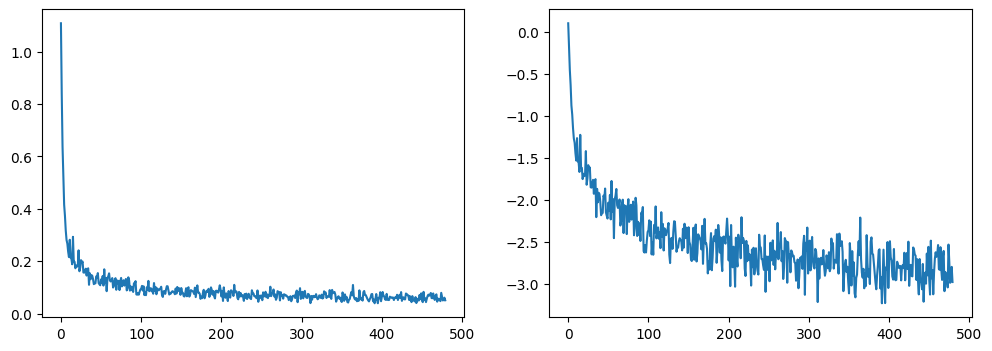

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## 5.生成图像

我们如何使用此模型生成图像？

在扩散模型里，「采样」（sample）过程指的是用训练好的去噪网络一步步把一张纯噪声转化成清晰图像的反向过程。可以把它理解为“照片冲洗”——你从一片看似随机的噪点开始，通过多次迭代，每一步都略微减少噪声、恢复细节，最终得到一张可读的图片。

### 方式一：创建一个pipeline

100%|██████████| 1000/1000 [00:11<00:00, 85.58it/s]


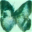

In [15]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe()
pipeline_output.images[0]

我们可以将pipeline保存到本地文件夹，如下所示：

In [16]:
image_pipe.save_pretrained("my_pipeline")

`scheduler` 和 `unet` 子文件夹包含重新创建这些组件所需的一切。例如，在 `unet` 文件夹内，你会找到模型权重（`diffusion_pytorch_model.bin`）以及指定 UNet 架构的配置文件。


### 方式二：编写采样循环

如果你查看pipeline的 `forward` 方法，你就能看到当我们运行 `image_pipe()` 时到底发生了什么：

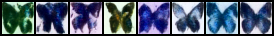

In [18]:
# ----------------------------------------
# 生成阶段：从随机噪声开始迭代地去噪，得到生成图像
# 随机初始化 8 张 32x32 图像的噪声样本
sample = torch.randn(8, 3, 32, 32).to(device)

# 依次遍历噪声调度器的时间步，从最高噪声到最低噪声
for i, t in enumerate(noise_scheduler.timesteps):
    # 在推理阶段无需计算梯度
    with torch.no_grad():
        # 使用模型预测当前样本的残差项（噪声）
        residual = model(sample, t).sample

    # 根据预测的残差和当前时间步，执行一步去噪更新，获得新的样本
    sample = noise_scheduler.step(residual, t, sample).prev_sample

# 将最终生成的图像样本可视化
show_images(sample)

`noise_scheduler.step()` 函数负责完成更新`sample`所需的数学计算。采样方法并不只有一种——在下一节中，我们将看看如何换用不同的采样器，以在现有模型下加速图像生成，并进一步探讨从扩散模型进行采样的理论。